In [1]:
import sys

sys.path.append("../")
from pathlib import Path

import polars as pl
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

from common.make_vec_env import make_vec_env
from envs.single_stock_trading_env import StockTradingEnv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TICKER = "SBIN.NS"
TRAIN_FILE = Path("../datasets") / f"{TICKER}_train"
EVAL_FILE = Path("../datasets") / f"{TICKER}_trade"

CLOSE_PRICES = pl.read_parquet(TRAIN_FILE)["Close"].to_numpy()
EVAL_CLOSE_PRICES = pl.read_parquet(EVAL_FILE)["Close"].to_numpy()

In [3]:
df = pl.read_parquet(TRAIN_FILE)
df.head(1)

Datetime,Close,High,Low,Ticker,Past1Hour,Past2Hour,Past3Hour,Past4Hour,Past5Hour,Past6Hour,Past7Hour,Past8Hour,Past9Hour,Past10Hour,Past11Hour,Past12Hour,Past13Hour,Past14Hour,Past15Hour,Past16Hour,Past17Hour,Past18Hour,Past19Hour,Past20Hour,Past21Hour,Past22Hour,Past23Hour,Past24Hour,Past25Hour,Past26Hour,Past27Hour,Past28Hour,Past29Hour,RSI,EMA9,EMA21,…,MOM,ROC,WILLR,PPO,Previous1Action,Previous2Action,Previous3Action,Previous4Action,Previous5Action,Previous6Action,Previous7Action,Previous8Action,Previous9Action,Previous10Action,Previous11Action,Previous12Action,Previous13Action,Previous14Action,Previous15Action,Previous16Action,Previous17Action,Previous18Action,Previous19Action,Previous20Action,Previous21Action,Previous22Action,Previous23Action,Previous24Action,Previous25Action,Previous26Action,Previous27Action,Previous28Action,Previous29Action,PortfolioValue,AvailableAmount,SharesHolding,CummulativeProfitLoss
"datetime[ns, UTC]",f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
2022-05-18 08:45:00 UTC,457.649994,460.950012,457.649994,"""SBIN.NS""",460.600006,461.399994,464.0,463.549988,465.25,467.450012,467.049988,466.0,462.700012,461.75,458.149994,458.100006,455.950012,454.049988,457.950012,454.850006,454.600006,458.399994,454.100006,440.549988,445.350006,462.0,468.0,467.100006,466.899994,465.149994,462.700012,462.850006,457.950012,44.093113,461.558907,461.413721,…,-4.100006,-0.887928,-73.955042,0.69917,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10000,10000,0,0


In [4]:
from datetime import datetime

df.set_sorted("Datetime").filter(
    pl.col("Datetime").dt.date() == (datetime(2022, 11, 17))
)

NameError: name 'df' is not defined

In [106]:
import json

track_portfolio = json.loads(
    Path(
        "../logs/single_stock_trading_past_n_price_portfolio_reward_a2c/6784000"
    ).read_text()
)["track_portfolio"]
pl.DataFrame(track_portfolio)

counter,buy_price,shares_holding,sell_price
i64,str,str,str
4,"""469.6""","""21.0""",null
441,null,"""21.0""","""526.4"""
461,"""528.0""","""21.0""",null
529,null,"""21.0""","""558.2"""
614,"""520.35""","""22.0""",null
789,null,"""22.0""","""615.9"""
803,"""601.5""","""23.0""",null
1149,null,"""23.0""","""594.6"""
1203,"""527.0""","""26.0""",null


In [144]:
(
    df.with_columns(index=pl.int_range(0, end=df.shape[0], eager=True))
    .sort("index")
    .set_sorted("index")
    .group_by_dynamic(
        "index", every="1i", period="40i", include_boundaries=True, closed="right"
    )
    .agg(pl.col("Close"))
    .with_columns(pl.col("Close").list.len().alias("Count"))
    .filter(pl.col("Count") == 40)
    .select(pl.col("Close"))
    .with_columns(
        [
            pl.col("Close").alias("past_n_prices"),
            pl.col("Close").list.min().alias("min"),
            pl.col("Close").list.max().alias("max"),
            pl.col("Close").list.mean().alias("mean"),
            pl.col("Close").list.last().alias("close"),
        ]
    )
    .with_columns(
        [
            ((pl.col("close") - pl.col("min")) / (pl.col("max") - pl.col("min")) * 100)
            .round(2)
            .alias("percentage_distance_from_min")
        ]
    )
    .with_columns(
        [
            (100 - pl.col("percentage_distance_from_min")).alias(
                "percentage_distance_from_max"
            )
        ]
    )
    .with_columns(
        [
            (pl.lit(5) > pl.col("percentage_distance_from_min")).alias(
                "closer_to_min_price_with_threshold"
            ),
            pl.int_range(0, pl.count()).alias("index"),
        ]
    )
    .join(
        pl.DataFrame(track_portfolio), left_on="index", right_on="counter", how="outer"
    )
    .drop(["Close", "index"])
    .with_columns(
        pl.when(pl.col("buy_price").is_not_null())
        .then(pl.lit("BUY"))
        .when(pl.col("sell_price").is_not_null())
        .then(pl.lit("SELL"))
        .otherwise(pl.lit("HOLD"))
        .alias("model_predicted")
    )
    .with_columns(
        [
            (pl.col("model_predicted") == "BUY").cum_sum().alias("region_start"),
            (pl.col("model_predicted") == "SELL")
            .cum_sum()
            .shift(1)
            .alias("region_end"),
        ]
    )
    .with_columns(
        [(pl.col("region_start") - pl.col("region_end")).alias("fill_region")]
    )
    .with_columns(
        [
            pl.when(pl.col("fill_region") > 0)
            .then(pl.col("shares_holding").forward_fill())
            .otherwise(pl.col("shares_holding"))
            .alias("shares_holding")
        ]
    )
    .with_columns(
        [
            pl.when(pl.col("fill_region") > 0)
            .then(pl.col("buy_price").forward_fill())
            .otherwise(pl.col("buy_price"))
            .alias("buy_price")
        ]
    )
    .drop(["region_start", "region_end", "fill_region"])
    .with_columns(
        [
            pl.when(
                (pl.col("model_predicted") == "HOLD")
                & (pl.col("shares_holding").is_null())
                & (pl.col("closer_to_min_price_with_threshold"))
            )
            .then((-(pl.col("percentage_distance_from_max")) * 10))
            .alias("reward")
        ]
    )
    .with_columns(
        [
            pl.when(
                (pl.col("model_predicted") == "HOLD")
                & (pl.col("shares_holding").is_null())
                & (~pl.col("closer_to_min_price_with_threshold"))
            )
            .then(pl.col("percentage_distance_from_max"))
            .alias("reward")
        ]
    )
    .with_columns(
        [
            pl.when(
                (pl.col("model_predicted") == "BUY")
                & (pl.col("closer_to_min_price_with_threshold"))
            )
            .then(pl.col("percentage_distance_from_max"))
            .otherwise(pl.col("reward"))
            .alias("reward")
        ]
    )
    .with_columns(
        [
            pl.when(
                (pl.col("model_predicted") == "BUY")
                & (~pl.col("closer_to_min_price_with_threshold"))
            )
            .then(-pl.col("percentage_distance_from_max"))
            .otherwise(pl.col("reward"))
            .alias("reward")
        ]
    )
    .with_columns(
        [
            pl.when(
                (pl.col("model_predicted") == "HOLD")
                & (~pl.col("closer_to_min_price_with_threshold"))
            )
            .then(-pl.col("percentage_distance_from_max"))
            .otherwise(pl.col("reward"))
            .alias("reward")
        ]
    )
    .with_columns(
        [
            pl.col("sell_price").cast(pl.Float32),
            pl.col("buy_price").cast(pl.Float32),
            pl.col("shares_holding").cast(pl.Float32),
        ]
    )
    .with_columns(
        [
            pl.when((pl.col("model_predicted") == "SELL"))
            .then(
                (
                    pl.col("sell_price") * pl.col("shares_holding")
                    - pl.col("buy_price") * pl.col("shares_holding")
                )
            )
            .otherwise(pl.col("reward"))
            .alias("reward")
        ]
    )
    .write_excel("../results/eval_results.xlsx")
    # .filter(pl.col("model_predicted")=="BUY")
    # .select("reward")
)

In [13]:
df.filter(pl.col("Close") == 598.5999755859375)

Datetime,Close,High,Low,Ticker,Past1Hour,Past2Hour,Past3Hour,Past4Hour,Past5Hour,Past6Hour,Past7Hour,Past8Hour,Past9Hour,Past10Hour,Past11Hour,Past12Hour,Past13Hour,Past14Hour,Past15Hour,Past16Hour,Past17Hour,Past18Hour,Past19Hour,Past20Hour,Past21Hour,Past22Hour,Past23Hour,Past24Hour,Past25Hour,Past26Hour,Past27Hour,Past28Hour,Past29Hour,RSI,EMA9,EMA21,…,MOM,ROC,WILLR,PPO,Previous1Action,Previous2Action,Previous3Action,Previous4Action,Previous5Action,Previous6Action,Previous7Action,Previous8Action,Previous9Action,Previous10Action,Previous11Action,Previous12Action,Previous13Action,Previous14Action,Previous15Action,Previous16Action,Previous17Action,Previous18Action,Previous19Action,Previous20Action,Previous21Action,Previous22Action,Previous23Action,Previous24Action,Previous25Action,Previous26Action,Previous27Action,Previous28Action,Previous29Action,PortfolioValue,AvailableAmount,SharesHolding,CummulativeProfitLoss
"datetime[ns, UTC]",f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
2022-11-17 08:45:00 UTC,598.599976,602.5,598.25,"""SBIN.NS""",601.599976,599.799988,597.200012,597.900024,598.099976,599.75,599.650024,599.849976,600.349976,601.25,601.099976,602.650024,601.5,599.950012,597.5,595.849976,594.599976,596.900024,598.0,592.900024,592.400024,596.400024,597.25,597.5,598.700012,599.650024,600.900024,601.5,600.950012,47.55773,599.324855,599.453901,…,-2.650024,-0.440753,-65.333659,0.207244,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10000,10000,0,0


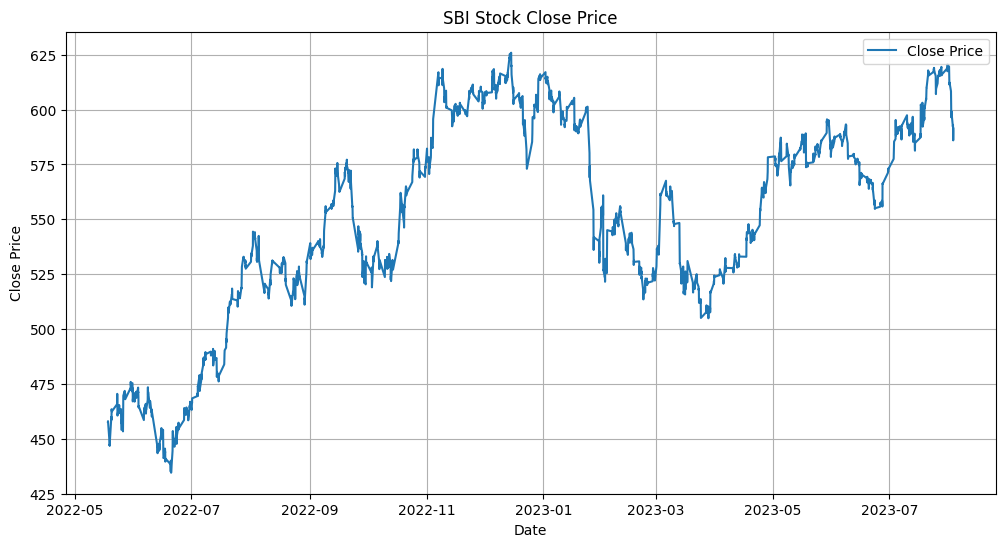

In [4]:
import matplotlib.pyplot as plt

# Plotting the Close price
plt.figure(figsize=(12, 6))
plt.plot(df["Datetime"], df["Close"], label="Close Price")
plt.title("SBI Stock Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
10000 // 425

23 * 625

14375

In [6]:
TRAIN_FILE = Path("../datasets") / f"{TICKER}_train"
df = pl.read_parquet(TRAIN_FILE)
CLOSE_PRICES = (
    df.with_columns(index=pl.int_range(0, end=df.shape[0], eager=True))
    .sort("index")
    .set_sorted("index")
    .group_by_dynamic(
        "index", every="1i", period="40i", include_boundaries=True, closed="right"
    )
    .agg(pl.col("Close"))
    .with_columns(pl.col("Close").list.len().alias("Count"))
    .filter(pl.col("Count") == 40)["Close"]
    .to_numpy()
)
CLOSE_PRICES

array([array([457.6499939 , 458.        , 448.95001221, 447.3999939 ,
              446.8999939 , 447.3999939 , 447.20001221, 446.8999939 ,
              449.20001221, 460.        , 459.3999939 , 458.54998779,
              463.45001221, 462.8999939 , 462.79998779, 462.3999939 ,
              465.75      , 466.6499939 , 470.45001221, 467.75      ,
              464.        , 460.54998779, 461.        , 464.8999939 ,
              462.95001221, 465.3500061 , 462.20001221, 462.45001221,
              461.6499939 , 463.3999939 , 461.54998779, 463.5       ,
              458.6499939 , 457.1000061 , 458.20001221, 454.79998779,
              454.1000061 , 454.        , 453.3999939 , 453.3500061 ]),
       array([458.        , 448.95001221, 447.3999939 , 446.8999939 ,
              447.3999939 , 447.20001221, 446.8999939 , 449.20001221,
              460.        , 459.3999939 , 458.54998779, 463.45001221,
              462.8999939 , 462.79998779, 462.3999939 , 465.75      ,
              466.

In [39]:
buy_flag = False
profit = 0
buy_price = -1
sell_price = -1

for i, ecp in enumerate(EVAL_CLOSE_PRICES):
    past_prices = ecp
    close_price = past_prices[-1]
    average_price = sum(ecp) / len(ecp)
    past_min_price = min(ecp)
    past_max_price = max(ecp)

    if close_price == past_min_price and not buy_flag:
        print("BUY", close_price, past_min_price)
        buy_flag = True
        sell_flag = False
        buy_price = close_price
        continue

    if close_price == past_max_price and buy_flag:
        p = (close_price - buy_price) * 20
        if p > 0:
            print("profit", close_price, past_max_price, p)
        else:
            print("loss", close_price, past_max_price, p)
        buy_flag = False
        profit += p

print(p)

BUY 464.29998779296875 464.29998779296875
profit 473.29998779296875 473.29998779296875 180.0
BUY 446.8500061035156 446.8500061035156
profit 455.3999938964844 455.3999938964844 170.999755859375
BUY 478.1499938964844 478.1499938964844
profit 491.5 491.5 267.0001220703125
BUY 517.0 517.0
profit 532.75 532.75 315.0
BUY 513.1500244140625 513.1500244140625
profit 529.9500122070312 529.9500122070312 335.999755859375
BUY 555.7000122070312 555.7000122070312
loss 540.0999755859375 540.0999755859375 -312.000732421875
BUY 522.4500122070312 522.4500122070312
profit 538.8499755859375 538.8499755859375 327.999267578125
BUY 608.8499755859375 608.8499755859375
loss 606.7999877929688 606.7999877929688 -40.999755859375
BUY 603.5499877929688 603.5499877929688
loss 556.0 556.0 -950.999755859375
BUY 535.9000244140625 535.9000244140625
loss 528.5999755859375 528.5999755859375 -146.0009765625
BUY 533.4500122070312 533.4500122070312
loss 521.9500122070312 521.9500122070312 -230.0
BUY 565.4500122070312 565.4500

In [54]:
min_price = 604
close_price = 618
max_price = 619

((close_price - min_price) / (max_price - min_price)) * 100

min_price - close_price

-14

In [ ]:
[·] Transaction #1874: Missed Buying Opportunity. Duration of Waiting: 1874 intervals. Current Share Price: ₹554.75. Average Price 565.5825012207031 is less than Buying Price 0.0 Minimum Price 554.75 Maximum Price 570.9000244140625 Reward Accumulated: ₹0.0. Portfolio Value: ₹10000.0.

In [46]:
close_price = 615
min_price = 604
max_price = 619
percentage_buy_threshold = 5


# Recalculating the percentage distance from min_price and max_price
percentage_distance_from_min = (
    (close_price - min_price) / (max_price - min_price)
) * 100
percentage_distance_from_max = 100 - percentage_distance_from_min

closer_to_min_price_with_threshold = (
    percentage_buy_threshold > percentage_distance_from_min
)

percentage_distance_from_min, percentage_distance_from_max, closer_to_min_price_with_threshold

(73.33333333333333, 26.66666666666667, False)

In [14]:
past_n_prices = EVAL_CLOSE_PRICES[0]
close_price = past_n_prices[-1]
available_amount = 10_000
shares_holding = 0
buy_price = 0
profit = 0
portfolio_value = available_amount

state = np.concatenate(
    (
        past_n_prices,
        np.array(
            (available_amount, shares_holding, buy_price, profit, portfolio_value)
        ),
    ),
    dtype=np.float32,
)
state

array([  457.65,   458.  ,   448.95,   447.4 ,   446.9 ,   447.4 ,
         447.2 ,   446.9 ,   449.2 ,   460.  ,   459.4 ,   458.55,
         463.45,   462.9 ,   462.8 ,   462.4 ,   465.75,   466.65,
         470.45,   467.75,   464.  ,   460.55,   461.  ,   464.9 ,
         462.95,   465.35,   462.2 ,   462.45,   461.65,   463.4 ,
         461.55,   463.5 ,   458.65,   457.1 ,   458.2 ,   454.8 ,
         454.1 ,   454.  ,   453.4 ,   453.35, 10000.  ,     0.  ,
           0.  ,     0.  , 10000.  ], dtype=float32)

In [24]:
past_n_prices = state[:-5]
close_price = past_n_prices[-1]
available_amount = state[-5]
shares_holding = state[-4]
buy_price = state[-3]
profit = state[-2]
portfolio_value = state[-1]

portfolio_value

10000.0

In [7]:
check_env(StockTradingEnv(CLOSE_PRICES, seed=0))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
env = StockTradingEnv(CLOSE_PRICES, seed=0)

In [5]:
obs, info = env.reset()
obs, info

(array([  457.65, 10000.  ,     0.  ,     0.  ], dtype=float32), {})

In [9]:
s, r, d, t, i = env.step(2)
i

{'seed': 0,
 'counter': 3,
 'close_price': 447.4,
 'predicted_action': 'SELL',
 'description': '22.0 shares sold at 447.40 with profit of -34.1005859375',
 'available_amount': 9965.899,
 'shares_holdings': 0,
 'buy_price': 0,
 'buy_price_index': -1,
 'reward': -34.1005859375,
 'done': False,
 'truncated': False,
 'correct_trade': 4,
 'wrong_trade': 0,
 'correct_trade %': 100.0,
 'buy_counter': 1,
 'sell_counter': 1,
 'hold_counter': 0,
 'good_hold_counter': 0,
 'good_sell_counter': 0,
 'good_buy_counter': 1,
 'bad_hold_counter': 0,
 'bad_sell_counter': 1,
 'bad_buy_counter': 0,
 'hold_with_no_shares_counter': 2,
 'good_hold_streak': 0,
 'bad_hold_streak': 0,
 'buy_counter %': 25.0,
 'good_sell_counter %': 0,
 'good_hold_counter %': 0,
 'bad_sell_counter %': 25.0,
 'bad_hold_counter %': 0,
 'holds_with_no_shares_counter %': 50.0,
 'good_hold_profit': 0,
 'good_sell_profit': 0,
 'good_buy_profit': 0,
 'bad_hold_loss': 0,
 'bad_sell_loss': -34.1005859375,
 'bad_buy_loss': 0,
 'good_moves'

In [18]:
df = pl.read_excel("../datasets/LabelTradeSBI.NS.xlsx")
df

Datetime,Close,RSI,EMA9,EMA21,MACD,MACD_SIGNAL,BBANDS_UPPER,BBANDS_MIDDLE,BBANDS_LOWER,ADX,STOCH_K,STOCH_D,ATR,CCI,MOM,ROC,WILLR,PPO,Actions
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""2023-08-04 03:…",592.599976,34.215289,593.04732,599.098184,-6.307788,-5.752122,617.59649,599.995004,582.393519,49.057268,66.097559,44.168844,4.162341,-56.254793,-3.900024,-0.653818,-68.801719,-1.776887,"""HOLD"""
"""2023-08-04 04:…",595.200012,39.898269,593.477859,598.743805,-5.79683,-5.761063,615.672932,599.085004,582.497075,49.078604,80.213751,61.716574,4.193601,-7.76646,-4.049988,-0.675843,-49.502458,-1.701393,"""HOLD"""
"""2023-08-04 05:…",596.799988,43.152731,594.142285,598.567094,-5.202812,-5.649413,613.624074,598.280002,582.93593,47.995942,89.26872,78.526677,4.158344,55.752468,-2.100037,-0.350649,-37.994763,-1.567384,"""HOLD"""
"""2023-08-04 06:…",593.0,37.903187,593.913828,598.060995,-4.981256,-5.515782,611.614952,597.360001,583.10505,47.412213,75.581632,81.688034,4.229174,18.573737,0.799988,0.135087,-49.683428,-1.479955,"""HOLD"""
"""2023-08-04 07:…",576.200012,24.00159,590.371065,596.073633,-6.091075,-5.63084,611.045368,595.585001,580.124633,48.706005,48.939613,71.263322,5.516376,-222.763293,-16.849976,-2.84124,-86.188757,-1.517362,"""HOLD"""
"""2023-08-04 08:…",573.900024,22.770303,587.076857,594.05785,-7.074652,-5.919603,609.851195,593.662503,577.473811,49.921356,22.926329,49.149192,5.67235,-233.637316,-18.0,-3.041054,-93.414121,-1.482601,"""HOLD"""
"""2023-08-04 09:…",573.200012,22.393764,584.301488,592.161683,-7.82048,-6.299778,608.931511,591.902502,574.873494,51.07946,9.433371,27.099771,5.45647,-190.258119,-17.149963,-2.90505,-94.20779,-1.48486,"""HOLD"""
"""2023-08-07 03:…",570.900024,21.155885,581.621195,590.228805,-8.49917,-6.739656,608.61177,590.242505,571.87324,52.291359,6.454252,12.937984,5.552435,-148.452113,-15.099976,-2.576788,-94.237247,-1.508338,"""HOLD"""
"""2023-08-07 04:…",568.200012,19.774005,578.936958,588.226187,-9.149436,-7.221612,608.403215,588.542505,568.681795,53.533983,5.361881,7.083168,5.50226,-133.378831,-22.599976,-3.825318,-96.671987,-1.534055,"""HOLD"""


In [22]:
# backtest
start_price = 10_000
(
    df.with_columns([pl.lit(10_000).alias("Available_Amount")]).with_columns(
        [
            pl.when(pl.col("Actions") == "BUY")
            .then(pl.col("Available_Amount") // pl.col("Close"))
            .then(
                pl.col("Available_Amount")
                - pl.col("Available_Amount") // pl.col("Close")
            )
            # .otherwise(0)
            .alias("Shares_Holdings")
        ]
    )
)

AttributeError: 'Then' object has no attribute 'then'

In [ ]:
# Attempting to buy without sufficient funds.
if predicted_action == "BUY" and close_price > available_amount

# Attempting to sell when no shares are held.
elif predicted_action == "SELL" and shares_holding == 0

# Buying Within Budget Good
elif predicted_action == "BUY" and close_price <= available_amount and close_price < average_past_n_prices

# Buying Within Budget BAD
elif predicted_action == "BUY" and close_price <= available_amount and close_price >= average_past_n_prices

# Checking for Profitable Sale
elif predicted_action == "SELL" and shares_holding > 0 and close_price > buy_price

# Avoiding Sale at a Loss
elif predicted_action == "SELL" and shares_holding > 0 and close_price <= buy_price

# Missed Good Buying Opportunity
elif predicted_action == "HOLD" and shares_holding == 0 and (close_price < holding_threshold)

# Correct Decision to Not Buy
elif predicted_action == "HOLD" and shares_holding == 0 and (close_price >= holding_threshold)


# Holding with shares (Profit)
elif predicted_action == "HOLD" and shares_holding > 0 and close_price >= buy_price

# Holding with shares (Loss)
elif predicted_action == "HOLD" and shares_holding > 0 and close_price < buy_price


In [12]:
import json
from pathlib import Path
import polars as pl

json_data = json.loads(Path("../logs/single_stock_trading_past_n_price_portfolio_reward_a2c/1024000").read_text())

pl.DataFrame(json_data).write_excel("../results/eval_results_a2c.xlsx")